### Metadata for simulator

In [15]:
from sumo_python.helpers.load_experiment_metadata import load_experiment_config

input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)

### Obtain ground-truth value

In [16]:
import numpy as np
import pandas as pd

from sumo_python.helpers.generate_od_xml import generate_od_xml
from sumo_python.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output
from sumo_python.simulator.ground_truth import run_ground_truth_and_parse
from sumo_python.helpers.nrmse_counts import compute_nrmse_counts

df_gt_data = run_ground_truth_and_parse(config, sim_setup)


od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

In [17]:
def objective(x: np.array) -> pd.DataFrame:
    """Compute objective variable. This is the NRMSE loss between ground-truth output
    and the output of the simulation output evaluated at x.

    Args:
        x (np.array): Numpy array of counts to generate TAZ file from.

    Returns:
        pd.Dataframe: Data frame of sampling locations and loss esimate.
    """
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

## Vanilla BO with Expected Improvement

In [18]:
# Bayesian optimization
import os
import torch
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space
d = 4 
bounds = torch.tensor([[400,400,400,400],[1000,1000,1000,1000]], device=device, dtype=dtype) 
bounds


tensor([[ 400.,  400.,  400.,  400.],
        [1000., 1000., 1000., 1000.]], dtype=torch.float64)

### Generate batch of policies using Sobol sequences


In [19]:
df_0 = pd.read_csv('./data/initial_sampling_locations.csv')

In [20]:
### GP model surrogate
from botorch.models.transforms import Standardize

from botorch.utils.transforms import normalize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll


train_X = torch.from_numpy(df_0[["x1","x2","x3","x4"]].values)
train_X_norm = normalize(train_X,bounds)

train_Y = -torch.from_numpy(df_0[["loss_estimate"]].values)


def initialize_gp_model(train_X,train_Y):
            
    gp_model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll


gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

# Fit model
fit_gpytorch_mll(gp_mll)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [21]:

### Acquisition Function: q-EI
# Acquisition function
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler

sampler = StochasticSampler(sample_shape=torch.Size([128]))
qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)

from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf
    
def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)


In [22]:

BATCH_SIZE = 1 
NUM_RESTARTS = 5 
RAW_SAMPLES = 32 

new_x = optimize_acqf_and_get_observation(
    acq_func=qEI,
    bounds=bounds
)

new_x

tensor([[993.6598, 876.8135, 961.7887, 509.0160]], dtype=torch.float64)

In [23]:

### Run loop
NITER = 100
output = [df_0]
best_value = []

for i in range(NITER):
    
    print(f"####### {i+1} ########")
    
    df_ = df_0 if i == 0 else df_i
    
    n_obs = df_.shape[0]
    print(f"##### n={n_obs} #####")
    
    # Training data
    train_X = torch.from_numpy(df_[["x1","x2","x3","x4"]].values)    
    train_X_norm = normalize(train_X,bounds)
    
    train_Y = -torch.from_numpy(df_[["loss_estimate"]].values) # Take negative
    
    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    
    # Maximize acquisition function to get next observation
    new_x = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)
    
    # Query SUMO on new sampling location
    df_simulation = objective(new_x.cpu().detach().numpy().reshape(-1))
    df_simulation['iter'] = i+1
    
    # Update history of training data
    output.append(df_simulation)
    
    df_i = pd.concat(output)

df = pd.concat(output)

####### 1 ########
##### n=20 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (9ms ~= 111.11*RT, ~99000.00UPS, vehicles TOT 3153 ACT 891 BUF 12)         


####### 2 ########
##### n=21 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~85666.67UPS, vehicles TOT 2973 ACT 771 BUF 0)          
####### 3 ########
##### n=22 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~65166.67UPS, vehicles TOT 3090 ACT 782 BUF 0)          
####### 4 ########
##### n=23 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~145000.00UPS, vehicles TOT 2854 ACT 725 BUF 0)         
####### 5 ###

Step #57600.00 (6ms ~= 166.67*RT, ~127500.00UPS, vehicles TOT 2856 ACT 765 BUF 290)       
####### 10 ########
##### n=29 #####
##### best_value=-0.01872436705548438 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~115400.00UPS, vehicles TOT 2737 ACT 577 BUF 0)         
####### 11 ########
##### n=30 #####
##### best_value=-0.01872436705548438 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~112166.67UPS, vehicles TOT 2925 ACT 673 BUF 0)         
####### 12 ########
##### n=31 #####
##### best_value=-0.01872436705548438 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step

Step #57600.00 (6ms ~= 166.67*RT, ~147833.33UPS, vehicles TOT 3105 ACT 887 BUF 172)       
####### 15 ########
##### n=34 #####
##### best_value=-0.01872436705548438 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~119400.00UPS, vehicles TOT 2655 ACT 597 BUF 0)         
####### 16 ########
##### n=35 #####
##### best_value=-0.01872436705548438 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (9ms ~= 111.11*RT, ~88888.89UPS, vehicles TOT 2970 ACT 800 BUF 116)        
####### 17 ########
##### n=36 #####
##### best_value=-0.018669214160848744 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~120857.14UPS, vehicles TOT 3052 ACT 846 BUF 0)         
####### 18 ########
##### n=37 #####
##### best_value=-0.018669214160848744 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (10ms ~= 100.00*RT, ~73700.00UPS, vehicles TOT 3034 ACT 737 BUF 52)        
####### 19 ########
##### n=38 #####
##### best_value=-0.018669214160848744 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (10ms ~= 100.00*RT, ~83200.00UPS, vehicles TOT 2926 ACT 832 BUF 341)       
####### 20 ########
##### n=39 #####
##### best_value=-0.018669214160848744 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (9ms ~= 111.11*RT, ~85444.44UPS, vehicles TOT 2803 ACT 769 BUF 406)        
####### 21 ########
##### n=40 #####
##### best_value=-0.018669214160848744 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (7ms ~= 142.86*RT, ~110428.57UPS, vehicles TOT 3067 ACT 773 BUF 30)        
####### 22 ########
##### n=41 #####
##### best_value=-0.018669214160848744 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (8ms ~= 125.00*RT, ~108125.00UPS, vehicles TOT 3007 ACT 865 BUF 151)       
####### 23 ########
##### n=42 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #56900.00

Step #57600.00 (6ms ~= 166.67*RT, ~139333.33UPS, vehicles TOT 2927 ACT 836 BUF 473)       
####### 24 ########
##### n=43 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~116800.00UPS, vehicles TOT 2724 ACT 584 BUF 0)         
####### 25 ########
##### n=44 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~103500.00UPS, vehicles TOT 3009 ACT 828 BUF 0)         
####### 26 ########
##### n=45 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step

Step #57600.00 (5ms ~= 200.00*RT, ~154800.00UPS, vehicles TOT 2850 ACT 774 BUF 433)       
####### 28 ########
##### n=47 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~122125.00UPS, vehicles TOT 2970 ACT 977 BUF 0)         
####### 29 ########
##### n=48 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (7ms ~= 142.86*RT, ~121571.43UPS, vehicles TOT 2908 ACT 851 BUF 162)       
####### 30 ########
##### n=49 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~126833.33UPS, vehicles TOT 2894 ACT 761 BUF 0)         
####### 31 ########
##### n=50 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (7ms ~= 142.86*RT, ~125428.57UPS, vehicles TOT 3259 ACT 878 BUF 285)       
####### 32 ########
##### n=51 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (6ms ~= 166.67*RT, ~132166.67UPS, vehicles TOT 2894 ACT 793 BUF 123)       
####### 33 ########
##### n=52 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~118600.00UPS, vehicles TOT 2680 ACT 593 BUF 0)         
####### 34 ########
##### n=53 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~84222.22UPS, vehicles TOT 2896 ACT 758 BUF 256)        
####### 35 ########
##### n=54 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (10ms ~= 100.00*RT, ~79300.00UPS, vehicles TOT 2943 ACT 793 BUF 227)       
####### 36 ########
##### n=55 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~122750.00UPS, vehicles TOT 2580 ACT 491 BUF 0)         
####### 37 ########
##### n=56 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~98888.89UPS, vehicles TOT 3143 ACT 890 BUF 9)          
####### 38 ########
##### n=57 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step

Step #57600.00 (9ms ~= 111.11*RT, ~102888.89UPS, vehicles TOT 3206 ACT 926 BUF 35)        
####### 47 ########
##### n=66 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~140500.00UPS, vehicles TOT 2808 ACT 562 BUF 0)         
####### 48 ########
##### n=67 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (3ms ~= 333.33*RT, ~163666.67UPS, vehicles TOT 2573 ACT 491 BUF 0)         
####### 49 ########
##### n=68 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step

####### 51 ########
##### n=70 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (13ms ~= 76.92*RT, ~69230.77UPS, vehicles TOT 2946 ACT 900 BUF 0)          
####### 52 ########
##### n=71 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~98571.43UPS, vehicles TOT 2393 ACT 690 BUF 0)          
####### 53 ########
##### n=72 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~72083.33UPS, vehicles TOT 3184 ACT 865 BUF 9)          
####

Step #57600.00 (4ms ~= 250.00*RT, ~178500.00UPS, vehicles TOT 2758 ACT 714 BUF 92)        
####### 58 ########
##### n=77 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~127000.00UPS, vehicles TOT 2668 ACT 635 BUF 0)         
####### 59 ########
##### n=78 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (6ms ~= 166.67*RT, ~133000.00UPS, vehicles TOT 2819 ACT 798 BUF 177)       
####### 60 ########
##### n=79 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~138500.00UPS, vehicles TOT 2919 ACT 831 BUF 0)         
####### 61 ########
##### n=80 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~146500.00UPS, vehicles TOT 2768 ACT 586 BUF 0)         
####### 62 ########
##### n=81 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step

Step #57600.00 (7ms ~= 142.86*RT, ~117000.00UPS, vehicles TOT 2946 ACT 819 BUF 252)       
####### 64 ########
##### n=83 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~165250.00UPS, vehicles TOT 2911 ACT 661 BUF 0)         
####### 65 ########
##### n=84 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~122400.00UPS, vehicles TOT 2707 ACT 612 BUF 0)         
####### 66 ########
##### n=85 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step

Step #57600.00 (5ms ~= 200.00*RT, ~146000.00UPS, vehicles TOT 2820 ACT 730 BUF 152)       
####### 70 ########
##### n=89 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~123800.00UPS, vehicles TOT 2743 ACT 619 BUF 0)         
####### 71 ########
##### n=90 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (6ms ~= 166.67*RT, ~134333.33UPS, vehicles TOT 2955 ACT 806 BUF 288)       
####### 72 ########
##### n=91 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (8ms ~= 125.00*RT, ~129875.00UPS, vehicles TOT 2969 ACT 1039 BUF 0)        
####### 73 ########
##### n=92 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~123750.00UPS, vehicles TOT 2267 ACT 495 BUF 0)         
####### 74 ########
##### n=93 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~120750.00UPS, vehicles TOT 2975 ACT 966 BUF 129)       
####### 75 ########
##### n=94 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (7ms ~= 142.86*RT, ~117000.00UPS, vehicles TOT 2861 ACT 819 BUF 313)       
####### 76 ########
##### n=95 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~135333.33UPS, vehicles TOT 2962 ACT 812 BUF 144)       
####### 77 ########
##### n=96 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (6ms ~= 166.67*RT, ~146166.67UPS, vehicles TOT 2918 ACT 877 BUF 222)       
####### 78 ########
##### n=97 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~146666.67UPS, vehicles TOT 3217 ACT 880 BUF 8)         
####### 79 ########
##### n=98 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~109500.00UPS, vehicles TOT 3030 ACT 876 BUF 0)         
####### 80 ########
##### n=99 #####
##### best_value=-0.00822469131529284 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (8ms ~= 125.00*RT, ~108875.00UPS, vehicles TOT 3031 ACT 871 BUF 256)       
####### 81 ########
##### n=100 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (6ms ~= 166.67*RT, ~122833.33UPS, vehicles TOT 2849 ACT 737 BUF 134)       
####### 82 ########
##### n=101 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (6ms ~= 166.67*RT, ~144000.00UPS, vehicles TOT 2988 ACT 864 BUF 259)       
####### 83 ########
##### n=102 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (3ms ~= 333.33*RT, ~154333.33UPS, vehicles TOT 2602 ACT 463 BUF 0)         
####### 84 ########
##### n=103 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (13ms ~= 76.92*RT, ~62923.08UPS, vehicles TOT 2890 ACT 818 BUF 54)         
####### 85 ########
##### n=104 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (3ms ~= 333.33*RT, ~166666.67UPS, vehicles TOT 1980 ACT 500 BUF 0)         
####### 86 ########
##### n=105 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (6ms ~= 166.67*RT, ~137666.67UPS, vehicles TOT 2953 ACT 826 BUF 147)       
####### 87 ########
##### n=106 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (10ms ~= 100.00*RT, ~84500.00UPS, vehicles TOT 2982 ACT 845 BUF 223)       
####### 88 ########
##### n=107 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (12ms ~= 83.33*RT, ~75166.67UPS, vehicles TOT 3014 ACT 902 BUF 104)        
####### 89 ########
##### n=108 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (14ms ~= 71.43*RT, ~64000.00UPS, vehicles TOT 3109 ACT 896 BUF 236)        
####### 90 ########
##### n=109 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (11ms ~= 90.91*RT, ~82363.64UPS, vehicles TOT 2955 ACT 906 BUF 162)        
####### 91 ########
##### n=110 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~107200.00UPS, vehicles TOT 2677 ACT 536 BUF 0)         
####### 92 ########
##### n=111 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (8ms ~= 125.00*RT, ~108750.00UPS, vehicles TOT 3053 ACT 870 BUF 468)       
####### 93 ########
##### n=112 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~97857.14UPS, vehicles TOT 2701 ACT 685 BUF 0)          
####### 94 ########
##### n=113 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (9ms ~= 111.11*RT, ~93888.89UPS, vehicles TOT 2739 ACT 845 BUF 3)          
####### 95 ########
##### n=114 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~78333.33UPS, vehicles TOT 2546 ACT 705 BUF 0)          
####### 96 ########
##### n=115 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (9ms ~= 111.11*RT, ~85333.33UPS, vehicles TOT 2767 ACT 768 BUF 560)        
####### 97 ########
##### n=116 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~83857.14UPS, vehicles TOT 2589 ACT 587 BUF 0)          
####### 98 ########
##### n=117 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.


Step #57600.00 (10ms ~= 100.00*RT, ~85600.00UPS, vehicles TOT 2966 ACT 856 BUF 175)       
####### 99 ########
##### n=118 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~97428.57UPS, vehicles TOT 2724 ACT 682 BUF 0)          
####### 100 ########
##### n=119 #####
##### best_value=-0.005921164764035104 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~101444.44UPS, vehicles TOT 3110 ACT 913 BUF 73)        


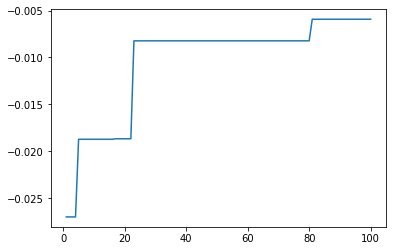

,x1,x2,x3,x4,loss_estimate,iter
0,827.374087,734.581889,862.086912,735.884932,0.008225,22
0,887.000152,696.128760,893.593150,811.491925,0.005921,80


In [24]:

df_plot = df.query('iter>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()
df.query('loss_estimate<0.010')